In [98]:
import os
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D, MaxPool2D
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
import glob
import shutil
import cv2
from keras.layers import Input
from keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential, Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [99]:
base_path = '../input/braintumor/Brain/train'
filepaths = []
labels = []
for (dir_path, dir_names, file_names) in os.walk(base_path):
    for i in file_names:
        filepaths.append(dir_path+'/'+i)
        if 'Tr-no' in (i.split('_')):
            labels.append("No")
        else:
            labels.append("Yes")
print('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  5712    labels:  5712


In [100]:
Files = pd.Series(filepaths, name='filepaths')
Label = pd.Series(labels, name='labels')
df = pd.concat([Files, Label], axis=1)
df = pd.DataFrame(np.array(df).reshape(5712, 2), columns=['filepaths', 'labels'])
df.head(10)

,filepaths,labels
0,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
1,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
2,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
3,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
4,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
5,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
6,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
7,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
8,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
9,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes


In [101]:
print(df['labels'].value_counts())

Yes    4128
No     1584
Name: labels, dtype: int64


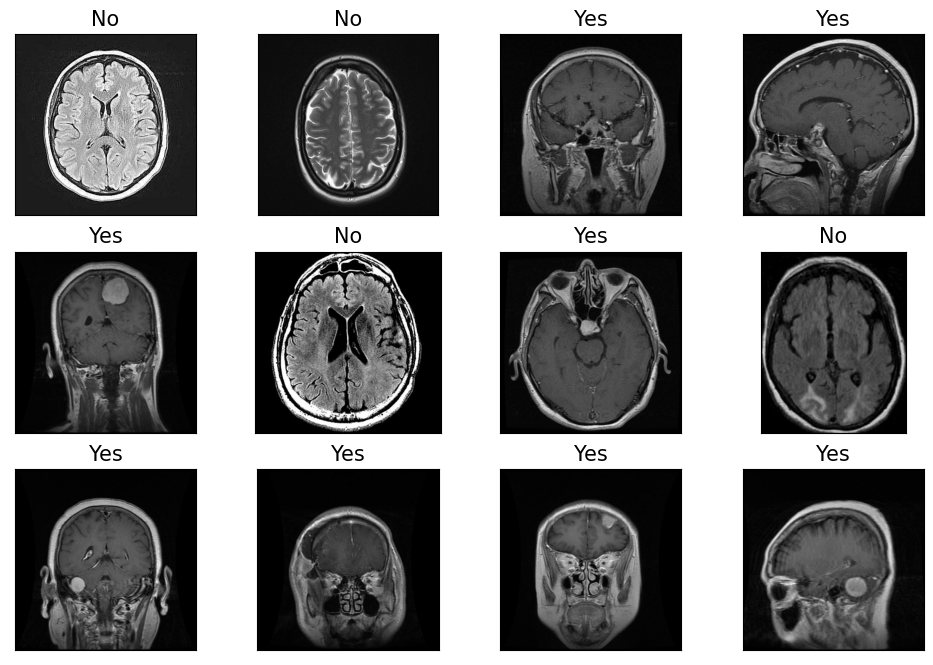

In [102]:
plt.figure(figsize=(12, 8))
for i in range(12):
    random = np.random.randint(1, len(df))
    plt.subplot(3, 4, i+1)
    plt.imshow(cv2.imread(df.loc[random, "filepaths"]))
    plt.title(df.loc[random, "labels"], size=15, color="black")
    plt.xticks([])
    plt.yticks([])

plt.show()

In [103]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.80, random_state=0)
train_new, valid = train_test_split(train, train_size=0.85, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (3883, 2)
test set shape: (1143, 2)
validation set shape: (686, 2)


In [104]:
train_datagen = ImageDataGenerator(rescale=1./255., rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

In [105]:
train_gen = train_datagen.flow_from_dataframe(dataframe=train_new, x_col='filepaths', y_col='labels', target_size=(150, 150), batch_size=16, class_mode='binary', shuffle=True)
val_gen = train_datagen.flow_from_dataframe(valid, target_size=(150, 150), x_col='filepaths', y_col='labels', class_mode='binary', batch_size=16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test, target_size=(150, 150), x_col='filepaths', y_col='labels', class_mode='binary', batch_size=16, shuffle=False)

Found 3883 validated image filenames belonging to 2 classes.
Found 686 validated image filenames belonging to 2 classes.
Found 1143 validated image filenames belonging to 2 classes.


In [106]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [107]:
input_data = Input(shape=(200, 200, 3), name='input')

base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape=(200, 200, 3), include_top=False)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 4, 4, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_5   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 128)               196736    
                                                                 
 batch_normalization_1223 (B  (None, 128)              512       
 atchNormalization)                                              
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                      